Dataset loaded successfully!
Shape: (27280, 21)

First 5 rows:
   year       age  gender_Female  gender_Male  race:AfricanAmerican  \
0  2020 -0.461171              1            0                     0   
1  2015 -0.595904              1            0                     0   
2  2015 -1.089926              0            1                     0   
3  2015 -0.056971              0            1                     0   
4  2016  0.437051              1            0                     1   

   race:Asian  race:Caucasian  race:Hispanic  race:Other  hypertension  ...  \
0           0               0              0           1             0  ...   
1           1               0              0           0             0  ...   
2           0               0              0           1             0  ...   
3           0               1              0           0             0  ...   
4           0               0              0           0             0  ...   

        bmi  hbA1c_level  blood_glu

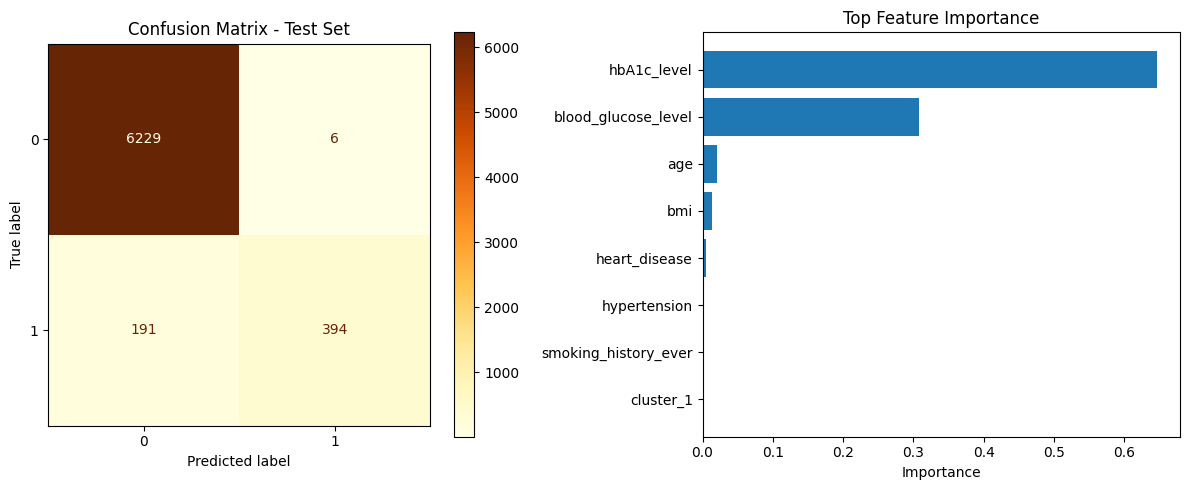


PREDICTION FUNCTION

EXAMPLE PREDICTIONS

Example 1 - High Risk Patient:

Predicting diabetes risk for patient:
  Age (standardized): 1.5
  BMI (standardized): 1.8
  HbA1c (standardized): 2.0
  Blood Glucose (standardized): 2.5

Assigned to Cluster: 0
Diabetes prevalence in Cluster 0: 55.9% (n=1915)

Prediction Results:
  Prediction: DIABETIC
  Probability (Diabetic): 99.8%
  Risk Level: HIGH RISK
  Recommendation: Immediate medical consultation recommended

------------------------------

Example 2 - Low Risk Patient:

Predicting diabetes risk for patient:
  Age (standardized): -1.0
  BMI (standardized): -0.5
  HbA1c (standardized): -1.0
  Blood Glucose (standardized): -1.0

Assigned to Cluster: 4
Diabetes prevalence in Cluster 4: 0.6% (n=7625)

Prediction Results:
  Prediction: NON-DIABETIC
  Probability (Diabetic): 0.1%
  Risk Level: LOW RISK
  Recommendation: Maintain healthy lifestyle with annual checkups

------------------------------

Example 3 - Moderate Risk Patient:

Predic

In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & Modeling
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, accuracy_score

# ============================================
#  Step 1: Load Dataset
# ============================================
df = pd.read_csv("model.csv")

print("Dataset loaded successfully!")
print("Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

# ============================================
# Step 2: Data Overview
# ============================================
print("\n" + "="*50)
print("DATA OVERVIEW")
print("="*50)
print(f"Total samples: {len(df)}")
print(f"Diabetes cases: {df['diabetes'].sum()} ({df['diabetes'].mean()*100:.1f}%)")

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# ============================================
#  Clustering
# ============================================
print("\n" + "="*50)
print("CLUSTERING")
print("="*50)

# Select features for clustering
features_for_clustering = [
    'age',
    'bmi',
    'hbA1c_level',
    'blood_glucose_level'
]

print(f"Clustering features: {features_for_clustering}")

# Check for missing values in clustering features
missing_in_cluster = df[features_for_clustering].isnull().sum()
print(f"\nMissing values in clustering features:")
print(missing_in_cluster)

# Handle missing values - drop rows with missing values for clustering
df_cluster_clean = df[features_for_clustering].dropna()
print(f"\nRows after dropping missing values for clustering: {len(df_cluster_clean)}")

# Prepare data for clustering
X_cluster = df_cluster_clean[features_for_clustering]

# Scale the data
scaler_cluster = StandardScaler()
X_scaled = scaler_cluster.fit_transform(X_cluster)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Create a copy of the original dataframe for clustering results
df_clean = df.loc[df_cluster_clean.index].copy()
df_clean['cluster'] = clusters

print(f"Number of clusters: 5")
print("\nCluster distribution:")
print(df_clean['cluster'].value_counts().sort_index())

# ============================================
#  Encoding
# ============================================
print("\n" + "="*50)
print("ENCODING")
print("="*50)

# Identify categorical columns for encoding
# First, let's see what columns we have
print("Dataframe columns:")
print(df_clean.columns.tolist())

# Based on your data, these appear to be the categorical columns (from one-hot encoding)
# Your data already has encoded columns like gender_Female, race:AfricanAmerican, etc.
# Let's identify which columns are categorical indicators
categorical_cols = ['cluster']  # We'll add cluster as categorical

# Check for columns that look like they're from one-hot encoding
encoded_patterns = ['gender_', 'race:', 'smoking_history_']
for col in df_clean.columns:
    if any(pattern in col for pattern in encoded_patterns):
        categorical_cols.append(col)

print(f"\nCategorical columns to encode: {categorical_cols}")

# One-hot encode the cluster variable
# Since other categoricals are already one-hot encoded, we only need to encode cluster
cluster_encoder = OneHotEncoder(drop='first', sparse_output=False)
cluster_encoded = cluster_encoder.fit_transform(df_clean[['cluster']])
cluster_encoded_df = pd.DataFrame(
    cluster_encoded,
    columns=cluster_encoder.get_feature_names_out(['cluster']),
    index=df_clean.index
)

# Combine with original features (excluding the original cluster column)
df_encoded = pd.concat([
    df_clean.drop(columns=['cluster']),
    cluster_encoded_df
], axis=1)

print(f"\nOriginal features: {len(df_clean.columns)}")
print(f"After encoding cluster: {len(df_encoded.columns)} features")

# ============================================
#  Classification Model
# ============================================
print("\n" + "="*50)
print("CLASSIFICATION MODEL")
print("="*50)

# Prepare features and target
# Exclude the target variable and any non-feature columns
X = df_encoded.drop(columns=['diabetes'])
y = df_clean['diabetes']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Training diabetes rate: {y_train.mean():.3f}")
print(f"Test diabetes rate: {y_test.mean():.3f}")

# Scale features (excluding already scaled/encoded features)
scaler_class = StandardScaler()
X_train_scaled = scaler_class.fit_transform(X_train)
X_test_scaled = scaler_class.transform(X_test)

# Train Gradient Boosting Classifier
print("\nTraining Gradient Boosting Classifier...")
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gb_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_train = gb_model.predict(X_train_scaled)
y_pred_test = gb_model.predict(X_test_scaled)

# Calculate metrics
print("\n=== Model Performance ===")
print("\nTraining Set:")
print(f"  Accuracy:  {accuracy_score(y_train, y_pred_train):.4f}")
print(f"  Precision: {precision_score(y_train, y_pred_train):.4f}")
print(f"  F1 Score:  {f1_score(y_train, y_pred_train):.4f}")

print("\nTest Set:")
print(f"  Accuracy:  {accuracy_score(y_test, y_pred_test):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_test):.4f}")
print(f"  F1 Score:  {f1_score(y_test, y_pred_test):.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

print("\nTop 10 Important Features:")
print(feature_importance)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Confusion Matrix
display = ConfusionMatrixDisplay(cm)
display.plot(ax=axes[0], cmap='YlOrBr')
axes[0].set_title('Confusion Matrix - Test Set')

# Plot 2: Feature Importance
top_features = feature_importance.head(8)
axes[1].barh(range(len(top_features)), top_features['importance'])
axes[1].set_yticks(range(len(top_features)))
axes[1].set_yticklabels(top_features['feature'])
axes[1].set_xlabel('Importance')
axes[1].set_title('Top Feature Importance')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# ============================================
#  Prediction Function
# ============================================
print("\n" + "="*50)
print("PREDICTION FUNCTION")
print("="*50)

def predict_diabetes(
    age, bmi, hbA1c_level, blood_glucose_level,
    gender_Female=0, gender_Male=0,
    race_AfricanAmerican=0, race_Asian=0, race_Caucasian=0, race_Hispanic=0, race_Other=0,
    hypertension=0, heart_disease=0,
    smoking_history_current=0, smoking_history_ever=0, smoking_history_former=0,
    smoking_history_never=0, smoking_history_not_current=0, smoking_history_No_Info=0,
    year=2020
):
    """
    Predict diabetes risk for a new patient.

    Required parameters:
    -------------------
    age : float
        Patient's age (standardized)
    bmi : float
        Body Mass Index (standardized)
    hbA1c_level : float
        Hemoglobin A1c level (standardized)
    blood_glucose_level : float
        Blood glucose level (standardized)

    Optional parameters:
    -------------------
    All other demographic and medical history features

    Returns:
    --------
    dict: Prediction results with probabilities and interpretation
    """

    print(f"\nPredicting diabetes risk for patient:")
    print(f"  Age (standardized): {age}")
    print(f"  BMI (standardized): {bmi}")
    print(f"  HbA1c (standardized): {hbA1c_level}")
    print(f"  Blood Glucose (standardized): {blood_glucose_level}")

    # Step 1: Prepare clustering features
    clustering_features = np.array([[age, bmi, hbA1c_level, blood_glucose_level]])

    # Step 2: Scale for clustering
    clustering_features_scaled = scaler_cluster.transform(clustering_features)

    # Step 3: Assign cluster
    cluster = kmeans.predict(clustering_features_scaled)[0]
    print(f"\nAssigned to Cluster: {cluster}")

    # Step 4: Prepare input dataframe with all features
    input_data = {
        'year': year,
        'age': age,
        'bmi': bmi,
        'hbA1c_level': hbA1c_level,
        'blood_glucose_level': blood_glucose_level,
        'gender_Female': gender_Female,
        'gender_Male': gender_Male,
        'race:AfricanAmerican': race_AfricanAmerican,
        'race:Asian': race_Asian,
        'race:Caucasian': race_Caucasian,
        'race:Hispanic': race_Hispanic,
        'race:Other': race_Other,
        'hypertension': hypertension,
        'heart_disease': heart_disease,
        'smoking_history_current': smoking_history_current,
        'smoking_history_ever': smoking_history_ever,
        'smoking_history_former': smoking_history_former,
        'smoking_history_never': smoking_history_never,
        'smoking_history_not current': smoking_history_not_current,
        'smoking_history_No Info': smoking_history_No_Info,
        'cluster': cluster
    }

    # Create dataframe
    new_df = pd.DataFrame([input_data])

    # Step 5: One-hot encode the cluster
    cluster_encoded_new = cluster_encoder.transform(new_df[['cluster']])
    cluster_encoded_new_df = pd.DataFrame(
        cluster_encoded_new,
        columns=cluster_encoder.get_feature_names_out(['cluster']),
        index=new_df.index
    )

    # Combine with other features (excluding original cluster)
    X_new = pd.concat([
        new_df.drop(columns=['cluster']).reset_index(drop=True),
        cluster_encoded_new_df.reset_index(drop=True)
    ], axis=1)

    # Step 6: Ensure all columns match training data
    # We need to reorder columns to match X_train
    for col in X.columns:
        if col not in X_new.columns:
            # Add missing columns with 0
            X_new[col] = 0

    # Reorder columns to match training data
    X_new = X_new[X.columns]

    # Step 7: Scale features
    X_new_scaled = scaler_class.transform(X_new)

    # Step 8: Make prediction
    proba = gb_model.predict_proba(X_new_scaled)[0]
    prediction = gb_model.predict(X_new_scaled)[0]

    # Step 9: Interpret results
    diabetes_prob = proba[1]

    if diabetes_prob >= 0.7:
        risk_level = "HIGH RISK"
        recommendation = "Immediate medical consultation recommended"
    elif diabetes_prob >= 0.4:
        risk_level = "MODERATE RISK"
        recommendation = "Regular monitoring and lifestyle changes advised"
    else:
        risk_level = "LOW RISK"
        recommendation = "Maintain healthy lifestyle with annual checkups"

    # Get cluster statistics
    if cluster in df_clean['cluster'].unique():
        cluster_stats = df_clean[df_clean['cluster'] == cluster]['diabetes'].mean() * 100
        cluster_count = df_clean[df_clean['cluster'] == cluster].shape[0]
        print(f"Diabetes prevalence in Cluster {cluster}: {cluster_stats:.1f}% (n={cluster_count})")

    # Prepare result
    result = {
        'prediction': int(prediction),
        'probability_diabetic': float(diabetes_prob),
        'probability_non_diabetic': float(proba[0]),
        'risk_level': risk_level,
        'recommendation': recommendation,
        'cluster': int(cluster)
    }

    print(f"\nPrediction Results:")
    print(f"  Prediction: {'DIABETIC' if prediction == 1 else 'NON-DIABETIC'}")
    print(f"  Probability (Diabetic): {diabetes_prob:.1%}")
    print(f"  Risk Level: {risk_level}")
    print(f"  Recommendation: {recommendation}")

    return result

# ============================================
#  Example Predictions
# ============================================
print("\n" + "="*50)
print("EXAMPLE PREDICTIONS")
print("="*50)

# Example 1: High risk patient (similar to diabetic profile)
print("\nExample 1 - High Risk Patient:")
result1 = predict_diabetes(
    age=1.5,  # Above average age (standardized)
    bmi=1.8,  # High BMI (standardized)
    hbA1c_level=2.0,  # High HbA1c (standardized)
    blood_glucose_level=2.5,  # High blood glucose (standardized)
    hypertension=1,  # Has hypertension
    gender_Male=1  # Male patient
)

print("\n" + "-"*30)

# Example 2: Low risk patient
print("\nExample 2 - Low Risk Patient:")
result2 = predict_diabetes(
    age=-1.0,  # Below average age (standardized)
    bmi=-0.5,  # Low BMI (standardized)
    hbA1c_level=-1.0,  # Low HbA1c (standardized)
    blood_glucose_level=-1.0,  # Low blood glucose (standardized)
    hypertension=0,  # No hypertension
    gender_Female=1  # Female patient
)

print("\n" + "-"*30)

# Example 3: Moderate risk patient
print("\nExample 3 - Moderate Risk Patient:")
result3 = predict_diabetes(
    age=0.5,  # Around average age (standardized)
    bmi=0.8,  # Slightly high BMI (standardized)
    hbA1c_level=0.3,  # Slightly elevated HbA1c (standardized)
    blood_glucose_level=0.4,  # Slightly elevated blood glucose (standardized)
    hypertension=0,  # No hypertension
    heart_disease=0,  # No heart disease
    gender_Female=1  # Female patient
)

# ============================================
#  Summary Statistics
# ============================================
print("\n" + "="*50)
print("SUMMARY STATISTICS")
print("="*50)

print("\nDiabetes by Cluster:")
cluster_diabetes = df_clean.groupby('cluster')['diabetes'].agg(['mean', 'count'])
cluster_diabetes['mean'] = cluster_diabetes['mean'] * 100
cluster_diabetes = cluster_diabetes.rename(columns={'mean': 'diabetes_%', 'count': 'patients'})
print(cluster_diabetes.round(1))

print("\nModel Performance Summary:")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test):.3f}")
print(f"Test Precision: {precision_score(y_test, y_pred_test):.3f}")
print(f"Test F1 Score: {f1_score(y_test, y_pred_test):.3f}")

print("\nFeature Importance Summary:")
print(f"Most important feature: {feature_importance.iloc[0]['feature']} "
      f"(importance: {feature_importance.iloc[0]['importance']:.3f})")
print(f"Second most important: {feature_importance.iloc[1]['feature']} "
      f"(importance: {feature_importance.iloc[1]['importance']:.3f})")

# Show cluster characteristics
print("\nCluster Characteristics (mean values):")
for cluster_num in sorted(df_clean['cluster'].unique()):
    cluster_data = df_clean[df_clean['cluster'] == cluster_num]
    print(f"\nCluster {cluster_num} (n={len(cluster_data)}):")
    print(f"  Diabetes rate: {cluster_data['diabetes'].mean()*100:.1f}%")
    print(f"  Avg age (std): {cluster_data['age'].mean():.3f}")
    print(f"  Avg BMI (std): {cluster_data['bmi'].mean():.3f}")
    print(f"  Avg HbA1c (std): {cluster_data['hbA1c_level'].mean():.3f}")
    print(f"  Avg Glucose (std): {cluster_data['blood_glucose_level'].mean():.3f}")

In [4]:
import joblib
# ============================================
#  Save Models and Transformers
# ============================================
print("\n" + "="*50)
print("SAVING MODELS AND TRANSFORMERS")
print("="*50)

# Save the classification model
joblib.dump(gb_model, 'diabetes_classification_model.pkl')
print("✓ Diabetes classification model saved")

# Save the scalers
joblib.dump(scaler_cluster, 'scaler_cluster.pkl')
print("✓ Cluster scaler saved")

joblib.dump(scaler_class, 'scaler_classification.pkl')
print("✓ Classification scaler saved")

# Save the encoders
joblib.dump(cluster_encoder, 'cluster_encoder.pkl')
print("✓ Cluster encoder saved")

# Save the clustering model
joblib.dump(kmeans, 'kmeans_cluster.pkl')
print("✓ KMeans clustering model saved")

# Save feature columns
joblib.dump(X.columns.tolist(), 'feature_columns.pkl')
print("✓ Feature columns saved")

# Save clustering features
joblib.dump(features_for_clustering, 'clustering_features.pkl')
print("✓ Clustering features saved")

# Save the complete pipeline information
pipeline_info = {
    'model_type': 'GradientBoostingClassifier',
    'n_clusters': 5,
    'clustering_features': features_for_clustering,
    'feature_columns': X.columns.tolist(),
    'test_accuracy': accuracy_score(y_test, y_pred_test),
    'test_precision': precision_score(y_test, y_pred_test),
    'test_f1_score': f1_score(y_test, y_pred_test)
}

joblib.dump(pipeline_info, 'pipeline_info.pkl')
print("✓ Pipeline information saved")

print("\n" + "="*50)
print("ALL MODELS AND TRANSFORMERS SAVED SUCCESSFULLY!")
print("="*50)
print("\nSaved files:")
print("1. diabetes_classification_model.pkl - Main classification model")
print("2. scaler_cluster.pkl - Scaler for clustering features")
print("3. scaler_classification.pkl - Scaler for classification features")
print("4. cluster_encoder.pkl - One-hot encoder for clusters")
print("5. kmeans_cluster.pkl - KMeans clustering model")
print("6. feature_columns.pkl - List of feature columns for classification")
print("7. clustering_features.pkl - List of features used for clustering")
print("8. pipeline_info.pkl - Pipeline metadata and performance metrics")


SAVING MODELS AND TRANSFORMERS
✓ Diabetes classification model saved
✓ Cluster scaler saved
✓ Classification scaler saved
✓ Cluster encoder saved
✓ KMeans clustering model saved
✓ Feature columns saved
✓ Clustering features saved
✓ Pipeline information saved

ALL MODELS AND TRANSFORMERS SAVED SUCCESSFULLY!

Saved files:
1. diabetes_classification_model.pkl - Main classification model
2. scaler_cluster.pkl - Scaler for clustering features
3. scaler_classification.pkl - Scaler for classification features
4. cluster_encoder.pkl - One-hot encoder for clusters
5. kmeans_cluster.pkl - KMeans clustering model
6. feature_columns.pkl - List of feature columns for classification
7. clustering_features.pkl - List of features used for clustering
8. pipeline_info.pkl - Pipeline metadata and performance metrics


In [5]:
import joblib

# Load all saved models and transformers
print("Loading saved models and transformers...")

# Load the classification model
gb_model = joblib.load('diabetes_classification_model.pkl')
print("✓ Diabetes classification model loaded")

# Load the scalers
scaler_cluster = joblib.load('scaler_cluster.pkl')
print("✓ Cluster scaler loaded")

scaler_class = joblib.load('scaler_classification.pkl')
print("✓ Classification scaler loaded")

# Load the encoder
cluster_encoder = joblib.load('cluster_encoder.pkl')
print("✓ Cluster encoder loaded")

# Load the clustering model
kmeans = joblib.load('kmeans_cluster.pkl')
print("✓ KMeans clustering model loaded")

# Load feature information
feature_columns = joblib.load('feature_columns.pkl')
print("✓ Feature columns loaded")

clustering_features = joblib.load('clustering_features.pkl')
print("✓ Clustering features loaded")

# Load pipeline information
pipeline_info = joblib.load('pipeline_info.pkl')
print("✓ Pipeline information loaded")

print("\n" + "="*50)
print("ALL MODELS AND TRANSFORMERS LOADED SUCCESSFULLY!")
print("="*50)

# Display pipeline information
print("\nPipeline Information:")
print(f"Model Type: {pipeline_info['model_type']}")
print(f"Number of Clusters: {pipeline_info['n_clusters']}")
print(f"Test Accuracy: {pipeline_info['test_accuracy']:.4f}")
print(f"Test Precision: {pipeline_info['test_precision']:.4f}")
print(f"Test F1 Score: {pipeline_info['test_f1_score']:.4f}")

print(f"\nClustering Features: {pipeline_info['clustering_features']}")
print(f"\nNumber of Feature Columns: {len(pipeline_info['feature_columns'])}")

# Example: Show first 10 feature columns
print(f"\nFirst 10 Feature Columns:")
for i, col in enumerate(pipeline_info['feature_columns'][:10]):
    print(f"  {i+1}. {col}")

Loading saved models and transformers...
✓ Diabetes classification model loaded
✓ Cluster scaler loaded
✓ Classification scaler loaded
✓ Cluster encoder loaded
✓ KMeans clustering model loaded
✓ Feature columns loaded
✓ Clustering features loaded
✓ Pipeline information loaded

ALL MODELS AND TRANSFORMERS LOADED SUCCESSFULLY!

Pipeline Information:
Model Type: GradientBoostingClassifier
Number of Clusters: 5
Test Accuracy: 0.9711
Test Precision: 0.9850
Test F1 Score: 0.8000

Clustering Features: ['age', 'bmi', 'hbA1c_level', 'blood_glucose_level']

Number of Feature Columns: 24

First 10 Feature Columns:
  1. year
  2. age
  3. gender_Female
  4. gender_Male
  5. race:AfricanAmerican
  6. race:Asian
  7. race:Caucasian
  8. race:Hispanic
  9. race:Other
  10. hypertension
